In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os

MODEL_DIR = 'dogidentificationapp/models/'

In [2]:
# define device to train on gpu, if printing cuda then it is okay even if not using cuda but AMD ROCm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## DATALOADING

In [3]:
import torch
from torchvision import datasets, transforms

# img_resolution = 32
img_resolution = 224

# Define the directory where your images are stored
data_dir = os.path.join('~', 'Datasets', 'Standford-Dog-Dataset', 'Images')
results_path = data_dir + '_results'

# Define transformations to be applied to each image when laoded
transform = transforms.Compose([
    transforms.Resize((img_resolution, img_resolution)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
    transforms.ToTensor(),
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 20580
    Root location: /home/killshot/Datasets/Standford-Dog-Dataset/Images
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               ToTensor()
           )


In [4]:
# Filter class names to be only dog breed names
class_names = [class_name.split('-')[-1] for class_name in dataset.classes]
print(class_names)
# save the filtered class names
with open(MODEL_DIR + 'class_names.txt', 'w') as f:
    for class_name in class_names:
        f.write(class_name + '\n')

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'coated_retriever', 'coated_retriever', 'golden_retrie

In [5]:
# split the data between training and validation sets
validation_size = 0.20
BATCH_SIZE = 64

# split dataset int training and validation
dataset_size = len(dataset)
val_dataset_size = int(validation_size * dataset_size)
train_dataset_size = dataset_size - val_dataset_size

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.01, 1.0)),
    transforms.ToTensor(),
])

train_dataset, validation_dataset = random_split(dataset, [train_dataset_size, val_dataset_size])

# apply data augmentation to training dataset
train_dataset.dataset.transform = augmentation

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

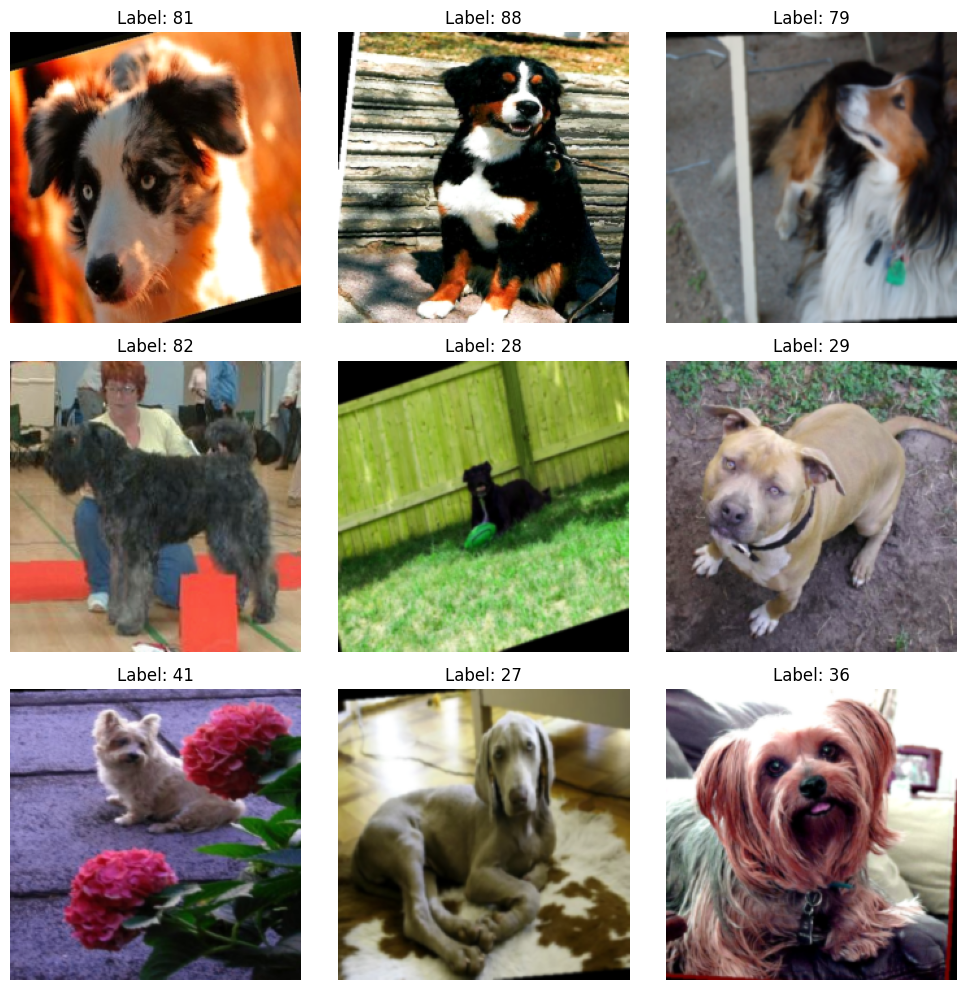

In [6]:
# check the resulting data augmentation on random samples

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Get the first batch of images and labels
images, labels = next(iter(train_dataloader))

# Create a figure and axes
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate over the images and labels and display them in the grid
for i in range(3):
    for j in range(3):
        # Convert the tensor image to a PIL image
        pil_image = TF.to_pil_image(images[i * 3 + j])
        
        # Display the image on the corresponding subplot
        axes[i, j].imshow(pil_image)
        axes[i, j].axis('off')  # Turn off axis
        axes[i, j].set_title(f"Label: {labels[i * 3 + j]}")
        
plt.tight_layout()  # Adjust layout
plt.show()



In [7]:
# Save class names to a file
with open('class_names.txt', 'w') as f:
    for class_name in class_names:
        f.write(class_name + '\n')

## Training Function

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np
import time

def train_model(results_path, model_name, model, train_loader, val_loader, lr, epoch, momentum, weight_decay, patience, n_epochs_stop):
    """
    """
    #if not os.path.exists(results_path+'/'+model_name):
    #    os.makedirs(results_path+'/'+model_name)
        
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.1, verbose=True)
    
    loaders = {'train': train_loader, 'val': val_loader}
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    
    y_testing = []
    preds = []
    
    min_val_loss = np.Inf
    epochs_no_improv = 0
    
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        print(f'Using {torch.cuda.device_count()} GPUs')
        model.cuda()
    else:
        print('Using CPU')
    
    start = time.time()
    for epoch in range(epochs):
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            if mode == 'val':
                model.eval()
            
            epoch_loss = 0
            epoch_acc = 0
            samples = 0

            for i, (inputs, targets) in enumerate(loaders[mode]):
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                
                optimizer.zero_grad()
                output = model(inputs)
                loss = criterion(output, targets)
                
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    y_testing.extend(targets.data.tolist())
                    preds.extend(output.max(1)[1].tolist())
                
                if torch.cuda.is_available():
                    acc = accuracy_score(targets.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())
                else:
                    acc = accuracy_score(targets.data, output.max(1)[1])

                epoch_loss += loss.data.item()*inputs.shape[0]
                epoch_acc += acc*inputs.shape[0]
                samples += inputs.shape[0]
                
                if i % (len(loaders[mode])//5) == 0:
                    print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss/samples:0.2f} Accuracy: {epoch_acc/samples:0.2f}')
            
            epoch_loss /= samples
            epoch_acc /= samples
            losses[mode].append(epoch_loss)
            accuracies[mode].append(epoch_acc)
            
            print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss:0.2f} Accuracy: {epoch_acc:0.2f}')
            
            if mode == 'val':
                scheduler.step(epoch_loss)
        
        if mode == 'val':
            if epoch_loss < min_val_loss:
                torch.save(model.state_dict(), MODEL_DIR+str(model_name)+'.pth')
                epochs_no_improv = 0
                min_val_loss = epoch_loss
            else:
                epochs_no_improv += 1
                print(f'Epochs with no improvement {epochs_no_improv}')
                if epochs_no_improv == n_epochs_stop:
                    print('Early stopping!')
                    return model, (losses, accuracies), y_testing, preds
                model.load_state_dict(torch.load(MODEL_DIR+str(model_name)+'.pth'))
                
    print(f'Training time: {time.time()-start} min.')
    return model, (losses, accuracies), y_testing, preds

def test_model(model_name, model, test_loader):
    model.load_state_dict(torch.load(MODEL_DIR+str(model_name)+'.pth'))

    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    
    preds = []
    trues = []
    
    for i, (inputs, targets) in enumerate(test_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            pred = model(inputs).data.cuda().cpu().numpy().copy()
        else:
            pred = model(inputs).data.numpy().copy()
            
        true = targets.numpy().copy()
        preds.append(pred)
        trues.append(true)

        if i % (len(test_loader)//5) == 0:
            print(f'Iteration {i+1}/{len(test_loader)}')
    return np.concatenate(preds), np.concatenate(trues)

## NN Model

In [9]:
import torchvision.models as models
import torch.nn as nn
import torch


def freeze_layers(trainable_layers: list):
    for name, child in model.named_children():
        if name not in trainable_layers:
            for param in child.parameters():
                param.requires_grad = False
            print(f'{name}; trainable: False')
        else:
            print(f'{name}; trainable: True')


# Define the model and freeze all layers except specified ones for transfer learning
model = models.resnet152(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, 120)
freeze_layers(trainable_layers=['layer3' ,'layer4', 'fc'])

# send model to gpu and print summary data about the model
model = model.to(device)
model

/home/killshot/Programmings/WebDev/Dog-Identification-Service/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/killshot/Programmings/WebDev/Dog-Identification-Service/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1; trainable: False
bn1; trainable: False
relu; trainable: False
maxpool; trainable: False
layer1; trainable: False
layer2; trainable: False
layer3; trainable: True
layer4; trainable: True
avgpool; trainable: False
fc; trainable: True


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
from torch.utils.tensorboard import SummaryWriter

dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Use TensorBoard to visualize the model
writer = SummaryWriter('runs/resnet152_experiment')
writer.add_graph(model, dummy_input)
writer.close()

print("Model graph has been written to TensorBoard logs.")

Model graph has been written to TensorBoard logs.


In [11]:
learning_rate = 0.01
net_name = "model_resnet152_v5"
epochs = 50
momentum = 0.9
weight_decay = 0.0005
patience = 3
n_epochs_stop = 8

model, loss_acc, y_testing, preds = train_model(results_path, net_name, model, train_dataloader, val_dataloader, 
                                                    learning_rate, epochs, momentum, weight_decay, patience, n_epochs_stop)

Using 1 GPUs


/home/killshot/Programmings/WebDev/Dog-Identification-Service/venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[train] Epoch 1/50 Iteration 1/258 Loss: 4.88 Accuracy: 0.00
[train] Epoch 1/50 Iteration 52/258 Loss: 3.04 Accuracy: 0.37
[train] Epoch 1/50 Iteration 103/258 Loss: 2.10 Accuracy: 0.52
[train] Epoch 1/50 Iteration 154/258 Loss: 1.74 Accuracy: 0.58
[train] Epoch 1/50 Iteration 205/258 Loss: 1.57 Accuracy: 0.61
[train] Epoch 1/50 Iteration 256/258 Loss: 1.44 Accuracy: 0.63
[train] Epoch 1/50 Iteration 258/258 Loss: 1.44 Accuracy: 0.63
[val] Epoch 1/50 Iteration 1/65 Loss: 1.63 Accuracy: 0.45
[val] Epoch 1/50 Iteration 14/65 Loss: 1.27 Accuracy: 0.63
[val] Epoch 1/50 Iteration 27/65 Loss: 1.23 Accuracy: 0.63
[val] Epoch 1/50 Iteration 40/65 Loss: 1.19 Accuracy: 0.65
[val] Epoch 1/50 Iteration 53/65 Loss: 1.18 Accuracy: 0.65
[val] Epoch 1/50 Iteration 65/65 Loss: 1.18 Accuracy: 0.65
[train] Epoch 2/50 Iteration 1/258 Loss: 0.66 Accuracy: 0.83
[train] Epoch 2/50 Iteration 52/258 Loss: 0.81 Accuracy: 0.76
[train] Epoch 2/50 Iteration 103/258 Loss: 0.78 Accuracy: 0.76
[train] Epoch 2/50 Iter

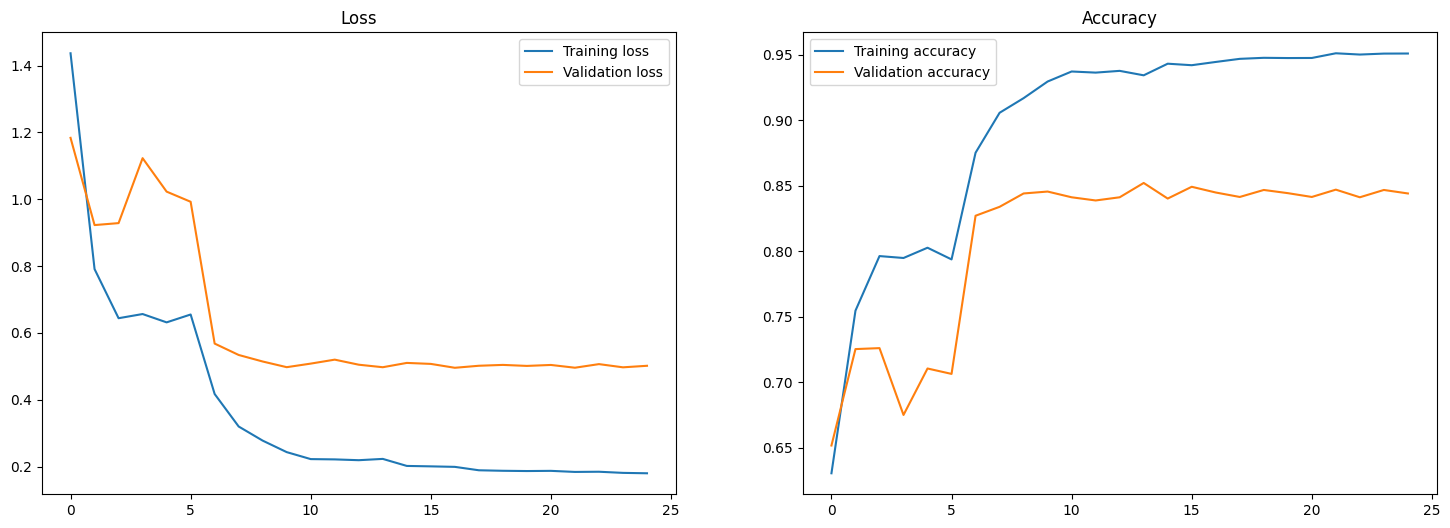

In [14]:
# display training results
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
x_range = np.arange(len(loss_acc[0]['train']))
plt.plot(x_range, loss_acc[0]['train'], label = 'Training loss')
plt.plot(x_range, loss_acc[0]['val'], label = 'Validation loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
x_range = np.arange(len(loss_acc[1]['train']))
plt.plot(x_range, loss_acc[1]['train'], label = 'Training accuracy')
plt.plot(x_range, loss_acc[1]['val'], label = 'Validation accuracy')
plt.title('Accuracy')
plt.legend()



In [15]:
# Save the model
torch.save(model, MODEL_DIR+str(net_name)+'.pth')